In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch,FontManager
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sqlite3
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from highlight_text import HighlightText, ax_text, fig_text
import unidecode
from PIL import Image
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('classic')

In [2]:
query = '''
SELECT
  TeamId,
  teams.team as team,
  PlayerId,
  players.player as Player,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
FROM
  `soccer-analytics-344915.Event_Data.EPL_2022` as epl
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Players` as players ON epl.PlayerId = players.id
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Teams` as teams ON epl.TeamId = teams.id
WHERE
  Type = 'Pass'
  AND OutcomeType = TRUE
'''

In [3]:
df = pd.read_gbq(query)
df['Player'] = df['Player'].apply(lambda x:unidecode.unidecode(x))
conn = sqlite3.connect(r'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\soccer_data.db')

In [4]:
def get_player_df(df, player,bins):
    player_df = df[df['Player'] == player]
    if len(player_df) == 0:
        print('No such player:', player)
        return 
    angle = player_df['Angle']
    player_df['Bins'] = pd.DataFrame(pd.cut(angle,bins=bins,include_lowest=True))
    length = player_df.groupby('Bins').mean()['Length']
    counts = player_df['Bins'].value_counts()
    working_df = pd.concat([length,counts],axis=1).reset_index()
    working_df['Midpoint'] = working_df['index'].apply(lambda x:x.mid)
    working_df.drop('index',axis=1,inplace=True)
    working_df.columns = ['Mean','Count','Midpoint']
    working_df['Scaled Length'] = working_df['Mean']**2
    mean_x = player_df['X'].mean()
    mean_y = player_df['Y'].mean()
    return player_df, working_df, mean_x,mean_y

In [5]:
def get_player_stats(team,conn,player): # Distance is in Yards
    team_query = f"SELECT Minutes_Played, Passes_Completed from Squad_Data WHERE Squad = '{team}'"
    team_df = pd.read_sql(team_query,conn)
    if len(team_df) == 0 :
        print('No Such Team:',team )
        return
    pass_per_90 = team_df['Passes_Completed']/team_df['Minutes_Played'] * 90
    player_query = f"SELECT Minutes_Played, Nineties, Passes_Completed, Pass_Completion_Percent, Total_Pass_Progressive_Distance from Players_Data WHERE Player LIKE '%{player}%' and Squad LIKE '%{team}%'"
    player_stats = pd.read_sql(player_query,conn)
    if len(player_stats) == 0:
        print('No Such Player:',player)
        return
    proportion = float((player_stats['Passes_Completed']/player_stats['Nineties'])/pass_per_90) * 100
    proportion = round(proportion,2)
    proportion = str(proportion) + '%'
    pass_pct = round(float(player_stats['Pass_Completion_Percent'].values),2)
    pass_pct = str(pass_pct) + '%'
    dist = int(player_stats['Total_Pass_Progressive_Distance']/player_stats['Nineties'])
    dist = str(dist) + ' yards'
    minutes = str(player_stats['Minutes_Played'].values[0]) + " Mins"
    return minutes, proportion, pass_pct, dist

NameError: name 'player_lst' is not defined

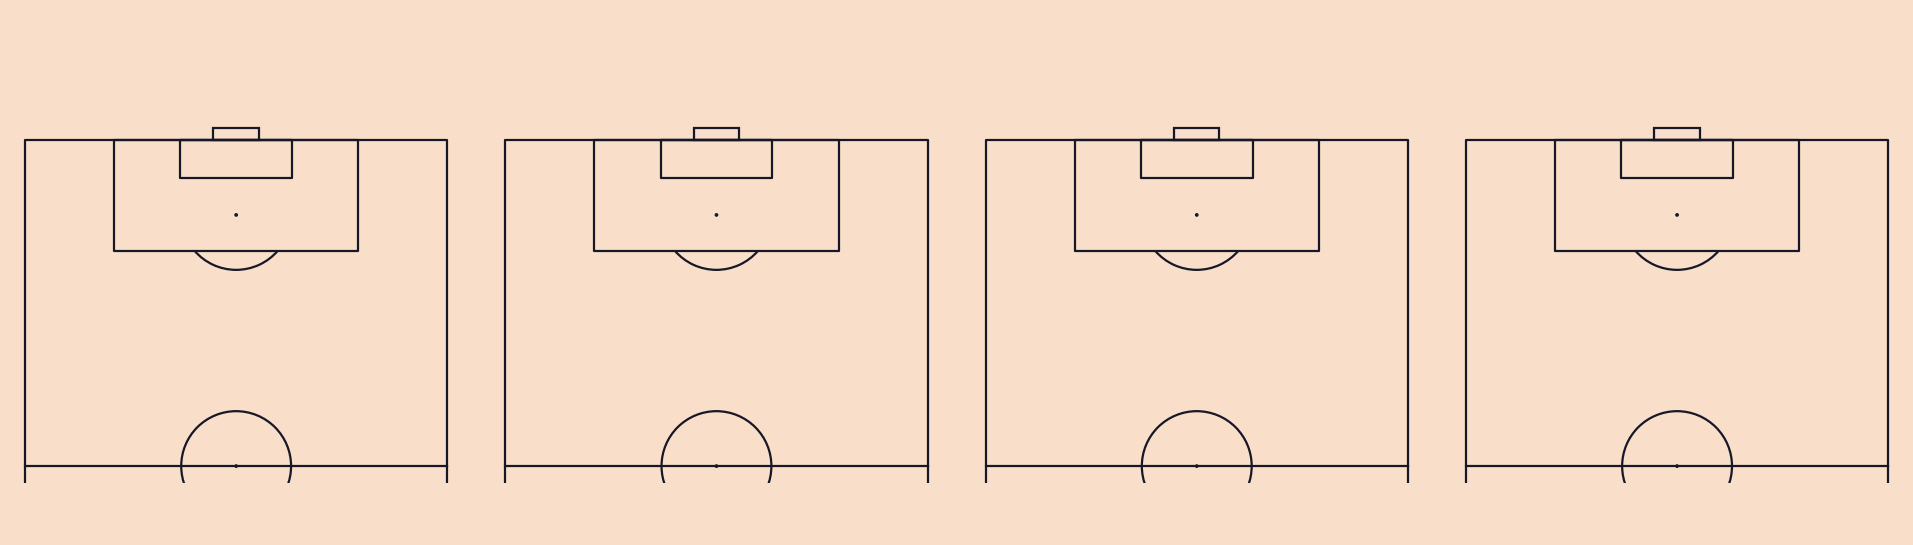

In [6]:
###Styles
pitch_line = '#161827'
bg_color = '#F9DEC9'
edge_color = '#161827'
title_color = '#161827'
text_color = '#161827'
stat_color = '#7C6354'
team_color = '#A31621'
player_size = 20 
stats_size = 17
title_size = 35
notes_size = 12
subtitle_size = 16
font = 'Bahnschrift'
title_font = 'Helvetica'
#title_font = 'Versa'
cmap_lst = [bg_color,'#DB222A','#A31621']


pitch = VerticalPitch(pitch_type='opta',pitch_color=bg_color,line_color=pitch_line,goal_type='box',half=True,line_zorder=2)
#hpitch = Pitch(pitch_type='opta')
fig, axs = pitch.grid(nrows=1,ncols=4,axis=False, grid_width=0.1,grid_height=0.5,space = 0.2)

#Colors
fig.set_facecolor(bg_color)
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256)

for idx,ax_pitch in enumerate(axs['pitch'].flat):
    player = player_lst[idx]
    bins = 10
    player_df, working_df,x,y = get_player_df(df,player,bins)

    #Heat Map
    bin_statistic = pitch.bin_statistic(player_df['PassEndX'],player_df['PassEndY'], statistic='count', bins=(50,35))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax_pitch, cmap=cmap, edgecolors=bg_color)
    #pcm = pitch.hexbin(player_df['PassEndX'],player_df['PassEndY'],ax=ax_pitch,edgecolors=bg_color,gridsize = (20,20),cmap=cmap)

    #Pie bar chart
    colors = plt.cm.ScalarMappable(cmap=cmap).to_rgba(working_df['Count']/working_df['Count'].mean())
    ax = inset_axes(ax_pitch,width=4,height= 3,axes_class = matplotlib.projections.get_projection_class('polar'),bbox_to_anchor=(0.5,-0.4),loc=10,bbox_transform=ax_pitch.transAxes)
    ax.set_theta_zero_location("N")
    ax.bar(working_df['Midpoint'],working_df['Scaled Length'],color = colors, edgecolor = edge_color)
    ax_pitch.text(50,106,player,horizontalalignment='center',fontsize= player_size,color = text_color,fontfamily=font)
    ax.axis('off')

    #Stats
    minutes, proportion,pass_pct,dist = get_player_stats(team,conn,player=player)
    ax_pitch.text(80,4,minutes,horizontalalignment='right',fontsize= stats_size,color = stat_color,fontfamily=font)
    ax_pitch.text(69,4,proportion,color = stat_color,fontsize=stats_size,fontfamily=font)
    ax_pitch.text(45,4,pass_pct,color = stat_color,fontsize=stats_size,fontfamily=font)
    ax_pitch.text(22,4,dist,color = stat_color,fontsize=stats_size,fontfamily=font)

#Colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)
cbar_ax = fig.add_axes([0.48,0.92,0.04,0.03],zorder=1)
cbar_ax.set_facecolor(bg_color)
cbar = plt.colorbar(cmappable,orientation = 'horizontal',ax=cbar_ax,fraction=0.9)
cbar_ax.axis('off')
cbar_ax.tick_params(size=0)
cbar.set_ticks([])
cbar.outline.set_visible(False)
axs['title'].text(0.34,1.4,'Low Quantity',fontsize=stats_size, va='center', ha='center',color = text_color,zorder=2,fontfamily=font)
axs['title'].text(0.66,1.4,'High Quantity',fontsize=stats_size, va='center', ha='center',color = text_color,zorder=2,fontfamily=font)


##Padding purposes
axs['pitch'][0].text(110,0,' ') 
axs['pitch'][-1].text(-10,0,' ')
axs['title'].text(0.5,2.35,' ') #top

#Title Texts at the top
#axs['title'].text(0.5, 2.1, f"How {team}'s Midfield Contributes in Build-up", fontsize=title_size, va='center', ha='center',color = title_color,zorder=2,fontfamily = title_font,fontweight='heavy')
fig_text(0.5,1.03,s = f"How <{team}'s> Midfield Contributes to Build-up",highlight_textprops= [{'color':team_color}] ,fontsize=title_size, va='center', ha='center',color = title_color,zorder=2,fontfamily =title_font,fontweight='heavy')
axs['title'].text(0.5, 1.8, 'Completed Passes into Opposition Half and Types of Pass Angles and Length', fontsize=subtitle_size, va='center', ha='center',color = text_color,zorder=2,fontfamily=font)
axs['title'].text(0.28, 1, "Minutes Played", fontsize=stats_size, va='center', ha='center',color = stat_color,zorder=2,fontfamily=font)
axs['title'].text(0.41, 1, "Proportion of Team's Passes", fontsize=stats_size, va='center', ha='center',color = stat_color,zorder=2,fontfamily=font)
axs['title'].text(0.56, 1, "Pass Completion %", fontsize=stats_size, va='center', ha='center',color = stat_color,zorder=2,fontfamily=font)
axs['title'].text(0.7, 1, "Progressive Distance /90", fontsize=stats_size, va='center', ha='center',color = stat_color,zorder=2,fontfamily=font)

#Add Logo
im = Image.open(rf'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\{team}.png')
im = im.convert('RGBA')
#convert to rgba 
h=bg_color.lstrip('#')
rgba = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
data = np.array(im)
red, green, blue, alpha = data.T 
white_areas = (red == 255) & (blue == 255) & (green == 255)
data[..., :-1][white_areas.T] = rgba
#add
logo_ax = fig.add_axes([0.458,0.85,0.2,0.2],anchor = 'NW')
logo_ax.axis('off')
logo_ax.imshow(data)

#Notes 
axs['endnote'].text(0,-6.4,'The Length of Each Bar Represents Mean Length of Completed Passes at Each Angle',color =text_color,fontsize=notes_size,fontstyle='italic',alpha=0.8,fontfamily=font)
axs['endnote'].text(0,-6.9,"Proportion of Team's Passes: Players Passes /90 divided by Team's Passes /90",color =text_color,fontsize=notes_size,fontstyle='italic',alpha=0.8,fontfamily=font)
#axs['endnote'].text(0.95,-6.8,'Created by: @nrehiew',color =text_color,fontsize=notes_size,fontstyle='italic',alpha=0.8)
plt.savefig('Liverpool.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=150)

In [7]:
teams = ['Arsenal',
 'Aston Villa', 
 'Brentford',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leeds',
 'Leicester City',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Southampton',
 'Tottenham',
 'Watford',
 'West Ham',
 'Wolves']

teams_working = ['Arsenal',
 'Aston Villa', 
 'Brentford',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leeds United',
 'Leicester',
 'Liverpool',
 'Manchester',
 'Manchester',
 'Newcastle',
 'Norwich',
 'Southampton',
 'Tottenham',
 'Watford',
 'West Ham',
 'Wolves']

In [8]:
players = ['Granit Xhaka','Douglas Luiz','Christian Norgaard','Yves Bissouma','Ashley Westwood','Jorginho','Cheikhou Kouyate','Allan','Mateusz Klich','Youri Tielemans','Fabinho','Rodri','Scott McTominay','Bruno Guimaraes','Mathias Normann','Oriol Romeu','Pierre Hojbjerg','Moussa Sissoko','Declan Rice','Ruben Neves']
players_ws = ['Granit Xhaka','Douglas Luiz','Christian Norgaard','Yves Bissouma','Ashley Westwood','Jorginho','Cheikhou Kouyate','Allan','Mateusz Klich','Youri Tielemans','Fabinho','Rodri','Scott McTominay','Bruno Guimaraes','Mathias Normann','Oriol Romeu','Pierre-Emile Hojbjerg','Moussa Sissoko','Declan Rice','Ruben Neves']

In [9]:
def get_player_stats_normalized(squad_team,player_team,conn,player): # Distance is in Yards 
    team_query = f"SELECT Minutes_Played, Passes_Completed from Squad_Data WHERE Squad = '{squad_team}'"
    team_df = pd.read_sql(team_query,conn)
    if len(team_df) == 0 :
        print('No Such Team:',squad_team)
        return
    pass_per_90 = team_df['Passes_Completed']/team_df['Minutes_Played'] * 90
    player_query = f"SELECT Minutes_Played, Nineties, Passes_Completed, Pass_Completion_Percent, Total_Pass_Progressive_Distance from Players_Data WHERE Player LIKE '%{player}%' and Squad LIKE '%{player_team}%'"
    player_stats = pd.read_sql(player_query,conn)
    if len(player_stats) == 0:
        print('No Such Player:',player)
        return
    proportion = float((player_stats['Passes_Completed']/player_stats['Nineties'])/pass_per_90) * 100
    proportion = round(proportion,2)
    proportion = str(proportion) + '%'
    pass_pct = round(float(player_stats['Pass_Completion_Percent'].values),2)
    pass_pct = str(pass_pct) + '%'
    dist = int(player_stats['Total_Pass_Progressive_Distance']/player_stats['Nineties'])
    dist = str(dist) + ' yards'
    minutes = str(player_stats['Minutes_Played'].values[0]) + " Mins"
    return minutes, proportion, pass_pct, dist

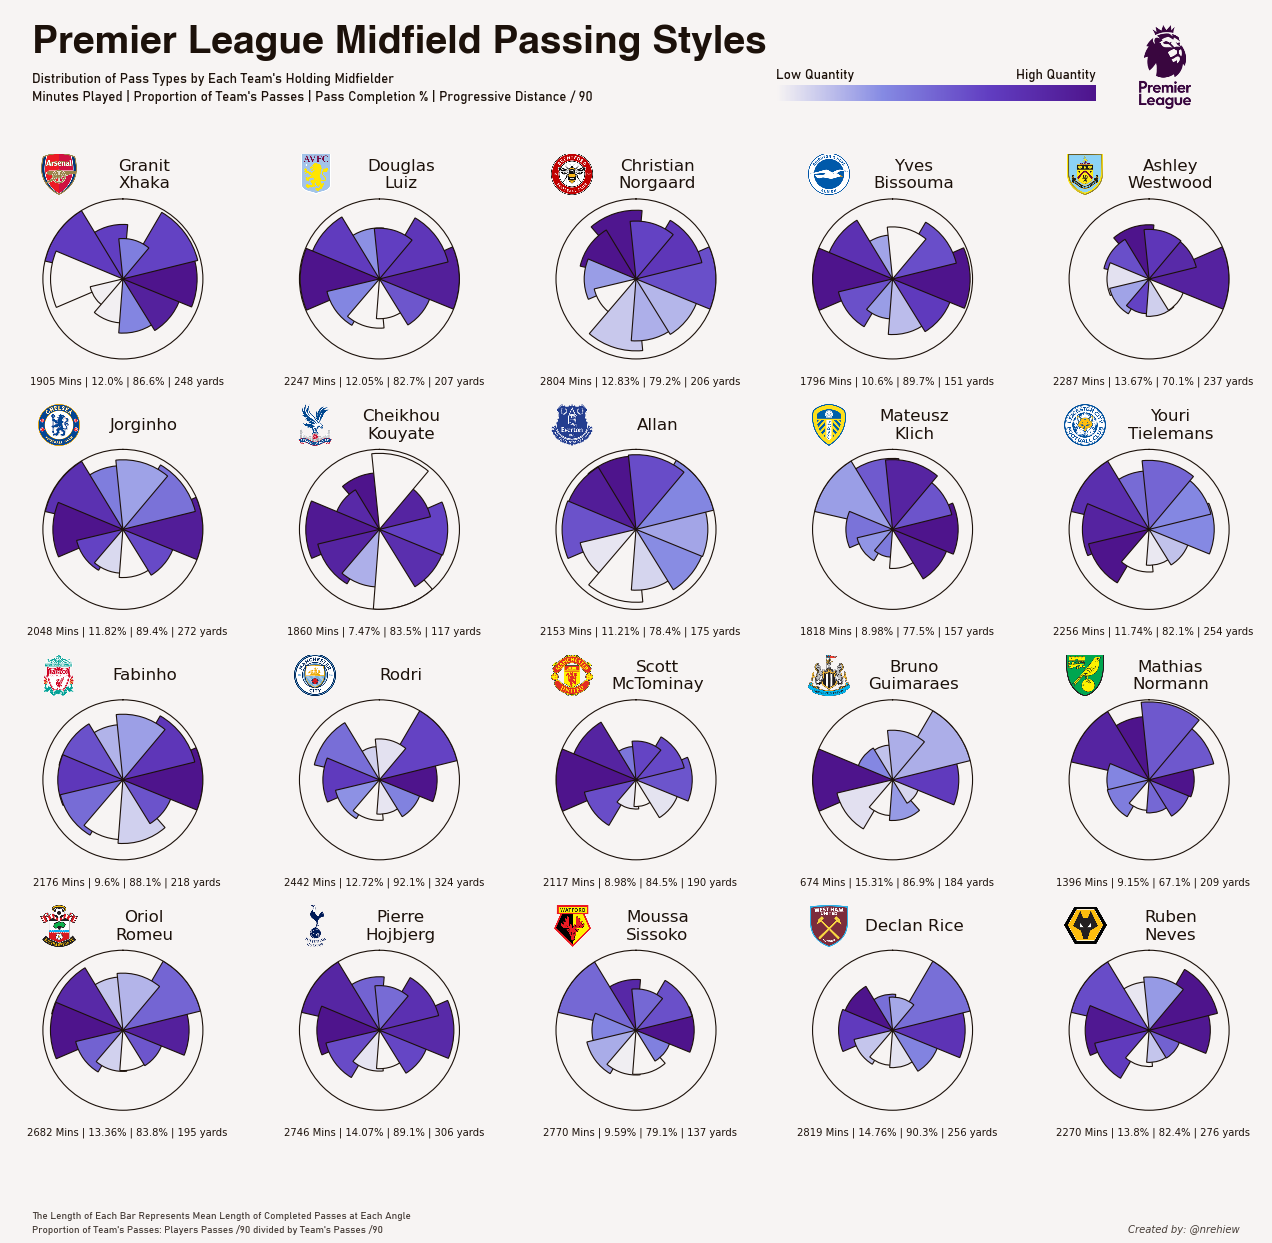

In [11]:
#Styles 
stats_size = 9
player_size = 15
team_size = 10
subtitle_size = 12
notes_size = 9
title_size = 35
bg_color = '#F7F4F3'
text_color = '#1C110A'
stat_color = '#1C110A'
title_color = '#1C110A'
edge_color= '#1C110A'
font = 'Bahnschrift'
title_font = 'Helvetica'
cmap_lst = [bg_color,'#858AE3','#613DC1','#4E148C']

fig, axs = plt.subplots(nrows=4, ncols=5, constrained_layout=False,figsize=(20,15))
fig.set_facecolor(bg_color)
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
for i, ax in enumerate(axs.reshape(-1)):
    polar = inset_axes(ax,width=2,height= 2,axes_class = matplotlib.projections.get_projection_class('polar'),loc=10)
    bins = 10
    player_df, working_df,x,y = get_player_df(df,players_ws[i],bins)
    colors = plt.cm.ScalarMappable(cmap=cmap).to_rgba(working_df['Count']/working_df['Count'].mean())
    polar.set_theta_zero_location("N")
    polar.bar(working_df['Midpoint'],working_df['Scaled Length'],color = colors, edgecolor = edge_color)
    player_text = ax.text(0.6,1,players[i],ha='center',va='center',fontsize = player_size,color = stat_color,wrap=True)
    player_text._get_wrap_line_width = lambda : 100
    #ax.text(0.5,0.93,teams[i],ha='center',va='center',fontsize = team_size,color = stat_color)
    ax.axis('off')
    #polar.axis('off')
    polar.xaxis.set_ticks([])
    polar.yaxis.set_ticks([])
    polar.set_facecolor(bg_color)
    polar.spines['polar'].set_color(edge_color)
    
    #add logo
    im = plt.imread(rf'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\{teams[i]}.png')
    logo = ax.inset_axes([0.1,0.9,0.2,0.2])
    logo.imshow(im)
    logo.axis('off')

    minutes, proportion,pass_pct,dist = get_player_stats_normalized(teams[i], teams_working[i],conn,player=players[i])
    # ax.text(0.05,0.02,minutes,fontsize=stats_size,color = stat_color,ha='left')
    # ax.text(0.33,0.02,proportion,fontsize=stats_size,color = stat_color)
    # ax.text(0.52,0.02,pass_pct,fontsize=stats_size,color = stat_color)
    # ax.text(0.95,0.02,dist,fontsize=stats_size,color = stat_color,ha='right')
    stats = ' | '.join([minutes, proportion,pass_pct,dist])
    ax.text(0.52,0.01,stats,fontsize=stats_size,color = stat_color,ha='center',va='center',zorder=3)

#padding 
fig.text(0.12,0.05,' ',ha='left')
fig.text(0.905,0.05,' ',ha='right')
fig.text(0.5,1.03,' ')

#Title
fig.text(0.135,1.01,s = "Premier League Midfield Passing Styles" ,fontsize=title_size, va='center', ha='left',color = title_color,zorder=2,fontfamily =title_font,fontweight='heavy')
fig.text(0.135, 0.98, "Distribution of Pass Types by Each Team's Holding Midfielder", fontsize=subtitle_size, va='center', ha='left',color = text_color,zorder=2,fontfamily=font)
fig.text(0.135, 0.965, "Minutes Played | Proportion of Team's Passes | Pass Completion % | Progressive Distance / 90", fontsize=subtitle_size, va='center', ha='left',color = text_color,zorder=2,fontfamily=font)


#League Logo
im = plt.imread(r'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Leagues\Premier League.png')
logo = fig.add_axes([0.808,0.955,0.07,0.07])
logo.imshow(im)
logo.axis('off')

cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)
cbar_ax = fig.add_axes([0.6,0.885,0.2,0.1],zorder=1)
cbar_ax.set_facecolor(bg_color)
cbar = plt.colorbar(cmappable,orientation = 'horizontal',ax=cbar_ax,fraction=0.9)
cbar_ax.axis('off')
cbar_ax.tick_params(size=0)
cbar.set_ticks([])
cbar.outline.set_visible(False)
plt.text(0,1.4,'Low Quantity',fontsize=subtitle_size, va='center', ha='left',color = text_color,zorder=2,fontfamily=font)
plt.text(1,1.4,'High Quantity',fontsize=subtitle_size, va='center', ha='right',color = text_color,zorder=2,fontfamily=font)

#ending text
fig.text(0.135,0.03,'The Length of Each Bar Represents Mean Length of Completed Passes at Each Angle',color =text_color,fontsize=notes_size,fontstyle='italic',alpha=0.8,fontfamily=font)
fig.text(0.135,0.018,"Proportion of Team's Passes: Players Passes /90 divided by Team's Passes /90",color =text_color,fontsize=notes_size,fontstyle='italic',alpha=0.8,fontfamily=font)
fig.text(0.89,0.018,'Created by: @nrehiew',color =text_color,fontsize=notes_size,fontstyle='italic',alpha=0.8,ha='right')
plt.savefig('epl.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)